In [1]:
# Import libraries
import numpy as np
import pandas as pd
import calendar
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
plt.style.use("fivethirtyeight")

from keras.models import Sequential
from keras.layers import Dense, LSTM

#  Data acquisition

In [2]:
# Read Dataset Master
data = pd.read_excel("Dataset_Pasut_2020-2022_rev.xlsx")
data.info

<bound method DataFrame.info of                      Time Water level
0     2020-01-01 00:00:00       1,383
1     2020-01-01 01:00:00       1,341
2     2020-01-01 02:00:00       1,475
3     2020-01-01 03:00:00       1,400
4     2020-01-01 04:00:00       1,583
...                   ...         ...
25955 2022-12-12 18:00:00       1,236
25956 2022-12-12 19:00:00       1,109
25957 2022-12-12 20:00:00       0,957
25958 2022-12-12 21:00:00       0,903
25959 2022-12-12 22:00:00       0,966

[25960 rows x 2 columns]>

In [3]:
# filtering dataset
data.set_index('Time', inplace=True) # indexing the 'Time' column
data = data[data['Water level'] != 0] # Drop the Value NaN/0
data["Water level"] = [float(str(i).replace(",", "")) for i in data["Water level"]] # Filtering the dataset Water level value/change to float

In [4]:
# Dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25960 entries, 2020-01-01 00:00:00 to 2022-12-12 22:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Water level  25960 non-null  float64
dtypes: float64(1)
memory usage: 405.6 KB


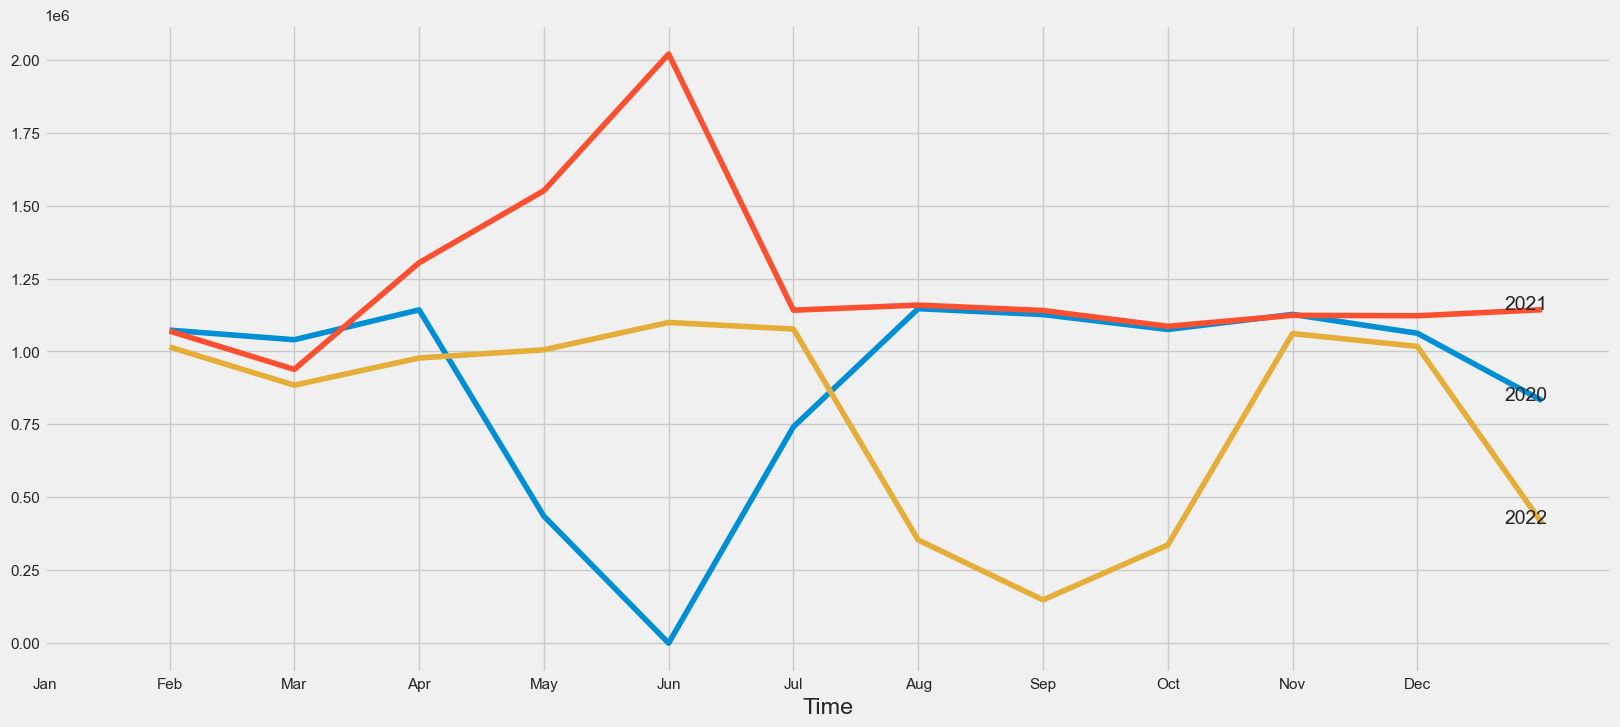

In [5]:
# PLot the timeseries dataset in Year
ts = data['Water level']

df_plot = ts.groupby([ts.index.month,ts.index.year]).sum().unstack()
df_plot

fig, ax = plt.subplots(figsize=(18,8))
df_plot.plot(ax=ax,legend=False)

# xticks
months = [calendar.month_abbr[i] for i in range(1,13)]
ax.set_xticks(range(12))
ax.set_xticklabels(months)

# plot names in the end
for col in df_plot.columns:
    plt.annotate(col,xy=(plt.xticks()[0][-1]+0.7, df_plot[col].iloc[-1]))
    
plt.savefig('Time Series by Year.jpg', dpi=300, bbox_inches='tight')

# Data exploration

In [6]:
df = data.copy()
df.reset_index(inplace=True)
df['year'] = df['Time'].dt.to_period('Y') # Make new column Year from dataset master
df

,Time,Water level,year
0,2020-01-01 00:00:00,1383.0,2020
1,2020-01-01 01:00:00,1341.0,2020
2,2020-01-01 02:00:00,1475.0,2020
3,2020-01-01 03:00:00,1400.0,2020
4,2020-01-01 04:00:00,1583.0,2020
...,...,...,...
25955,2022-12-12 18:00:00,1236.0,2022
25956,2022-12-12 19:00:00,1109.0,2022
25957,2022-12-12 20:00:00,957.0,2022
25958,2022-12-12 21:00:00,903.0,2022


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25960 entries, 0 to 25959
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         25960 non-null  datetime64[ns]
 1   Water level  25960 non-null  float64       
 2   year         25960 non-null  period[A-DEC] 
dtypes: datetime64[ns](1), float64(1), period[A-DEC](1)
memory usage: 608.6 KB


In [8]:
df= df[df['Water level'] != 0]

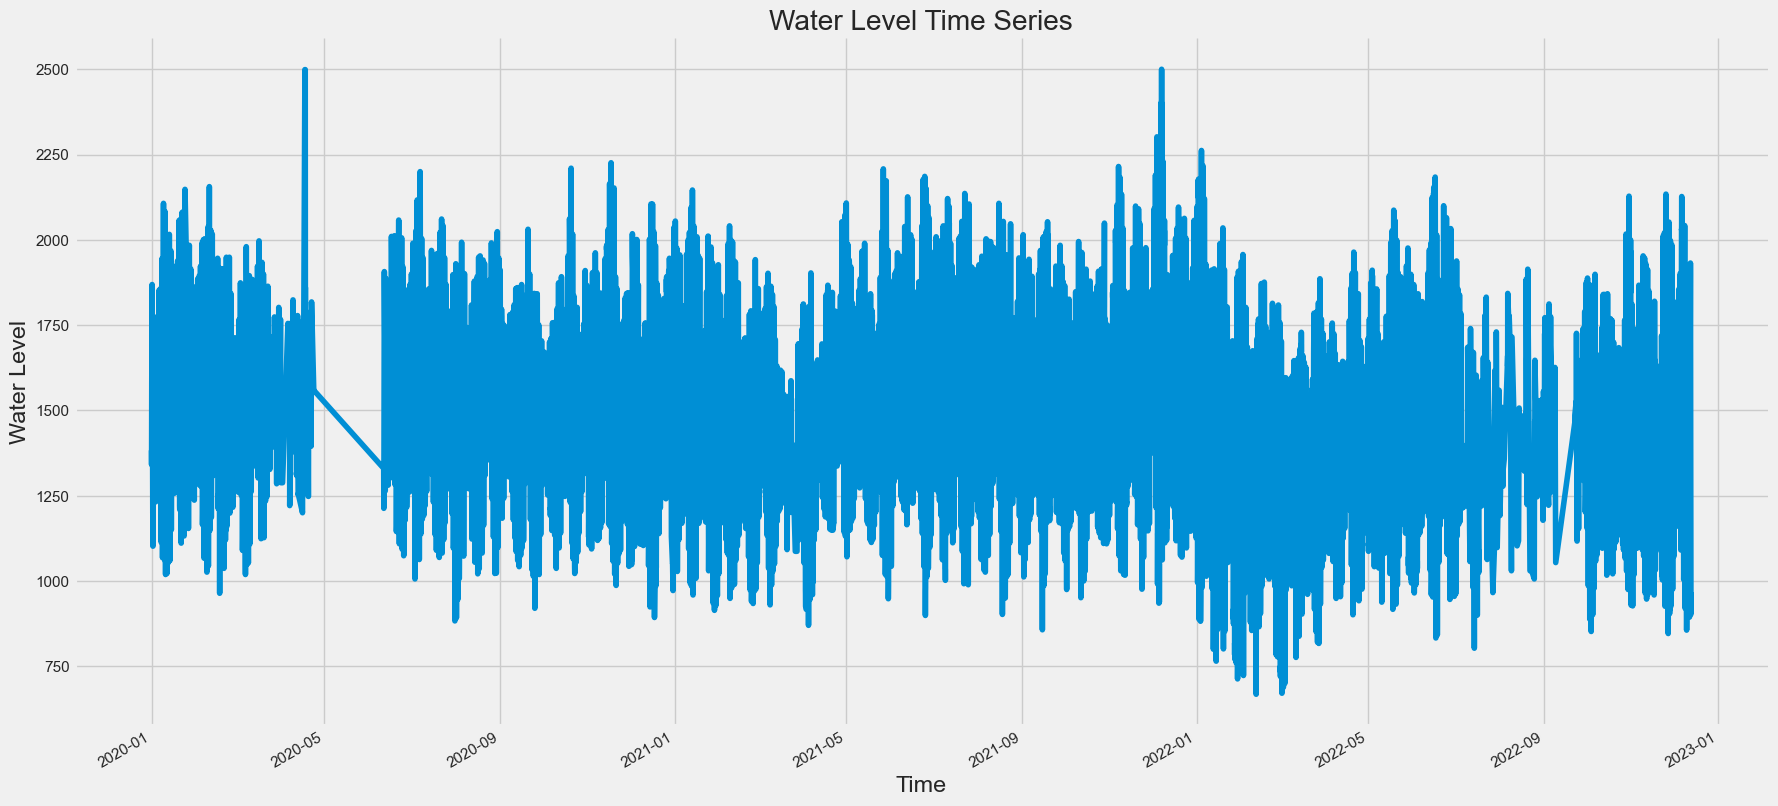

In [9]:
df1=df.loc[:,['Time','Water level']]
df1.set_index('Time',inplace=True)
df1.plot(figsize=(18,8))
plt.ylabel('Water Level')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Water Level Time Series')
sns.despine(top=True)
plt.savefig('Water level time seris.jpg', dpi=300, bbox_inches='tight')
plt.show();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


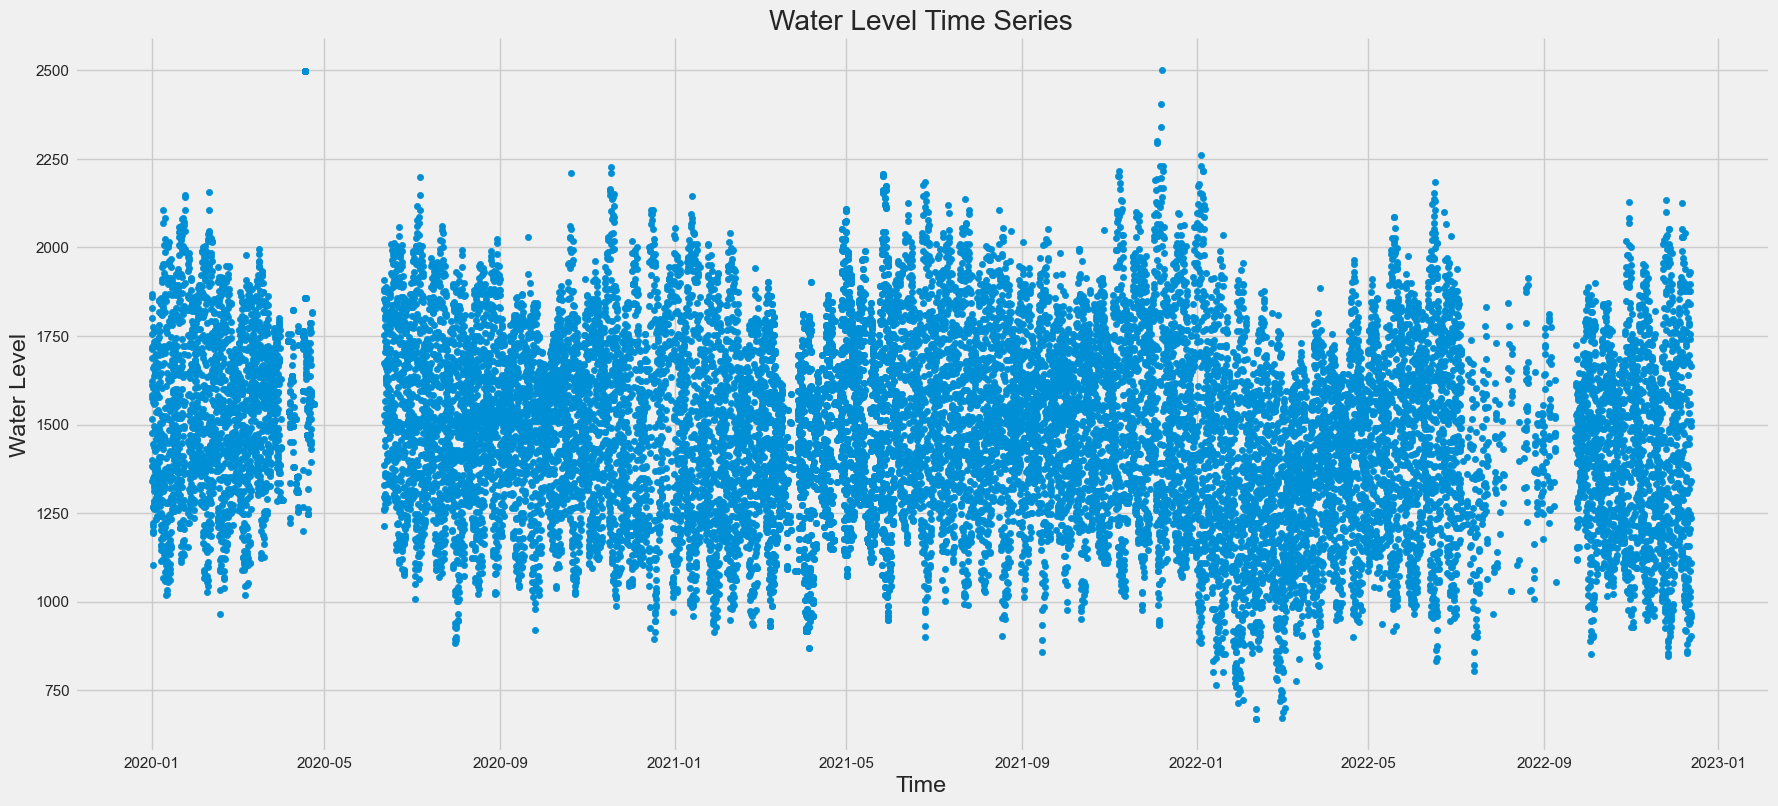

In [10]:
df2 = df.copy()
df2.plot.scatter(x='Time', y='Water level', figsize=(18,8))
plt.ylabel('Water Level')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Water Level Time Series')
sns.despine(top=True)
plt.savefig('Water Level Scatter plot.jpg', dpi=300, bbox_inches='tight')
plt.show();

In [11]:
import plotly.express as px

fig = px.scatter(df, x='Time', y="Water level") #show detail Water level all time with plotly express
fig.show()

# Modeling 

In [12]:
# Create a new dataframe with only the Water Level column 
data = df2.filter(['Water level'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

22327

In [13]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.39028384],
       [0.36735808],
       [0.44050218],
       ...,
       [0.15775109],
       [0.12827511],
       [0.16266376]])

In [14]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.39028384, 0.36735808, 0.44050218, 0.39956332, 0.49945415,
       0.52074236, 0.51582969, 0.57041485, 0.63373362, 0.65065502,
       0.65556769, 0.61899563, 0.59334061, 0.57423581, 0.55731441,
       0.49454148, 0.46233624, 0.38864629, 0.37227074, 0.32696507,
       0.32696507, 0.28984716, 0.30240175, 0.28820961, 0.23689956,
       0.2871179 , 0.29748908, 0.38973799, 0.42467249, 0.48908297,
       0.50982533, 0.54203057, 0.57587336, 0.60480349, 0.59825328,
       0.57751092, 0.58187773, 0.54421397, 0.52893013, 0.48580786,
       0.45196507, 0.41921397, 0.37445415, 0.36189956, 0.33569869,
       0.32969432, 0.32368996, 0.33460699, 0.35207424, 0.35862445,
       0.37336245, 0.38973799, 0.41266376, 0.44650655, 0.49727074,
       0.50927948, 0.53548035, 0.55949782, 0.58351528, 0.53275109])]
[0.5087336244541485]

[array([0.39028384, 0.36735808, 0.44050218, 0.39956332, 0.49945415,
       0.52074236, 0.51582969, 0.57041485, 0.63373362, 0.65065502,
       0.65556769, 0.61899563, 0.593

In [15]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
22267/22267 [==============================] - 804s 36ms/step - loss: 0.0022
Epoch 2/10
22267/22267 [==============================] - 558s 25ms/step - loss: 0.0016
Epoch 3/10
22267/22267 [==============================] - 535s 24ms/step - loss: 0.0015
Epoch 4/10
22267/22267 [==============================] - 544s 24ms/step - loss: 0.0015
Epoch 5/10
22267/22267 [==============================] - 545s 24ms/step - loss: 0.0014
Epoch 6/10
22267/22267 [==============================] - 538s 24ms/step - loss: 0.0014
Epoch 7/10
22267/22267 [==============================] - 533s 24ms/step - loss: 0.0014
Epoch 8/10
22267/22267 [==============================] - 532s 24ms/step - loss: 0.0014
Epoch 9/10
22267/22267 [==============================] - 536s 24ms/step - loss: 0.0014
Epoch 10/10
22267/22267 [==============================] - 529s 24ms/step - loss: 0.0013


# Model Evaluation

In [16]:
# Create the testing data set
# Create a new array containing scaled values
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

37/37 [==============================] - 3s 28ms/step


58.11931832965032

In [17]:
print(mean_absolute_error(y_test, predictions)) # Mean absolute error

44.4268017578125


In [18]:
np.mean(np.abs((y_test - predictions)/y_test))*100 # Mean absolute percentage error

3.2327753724105888

C:\Users\naabi\AppData\Local\Temp\ipykernel_22696\1650585629.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



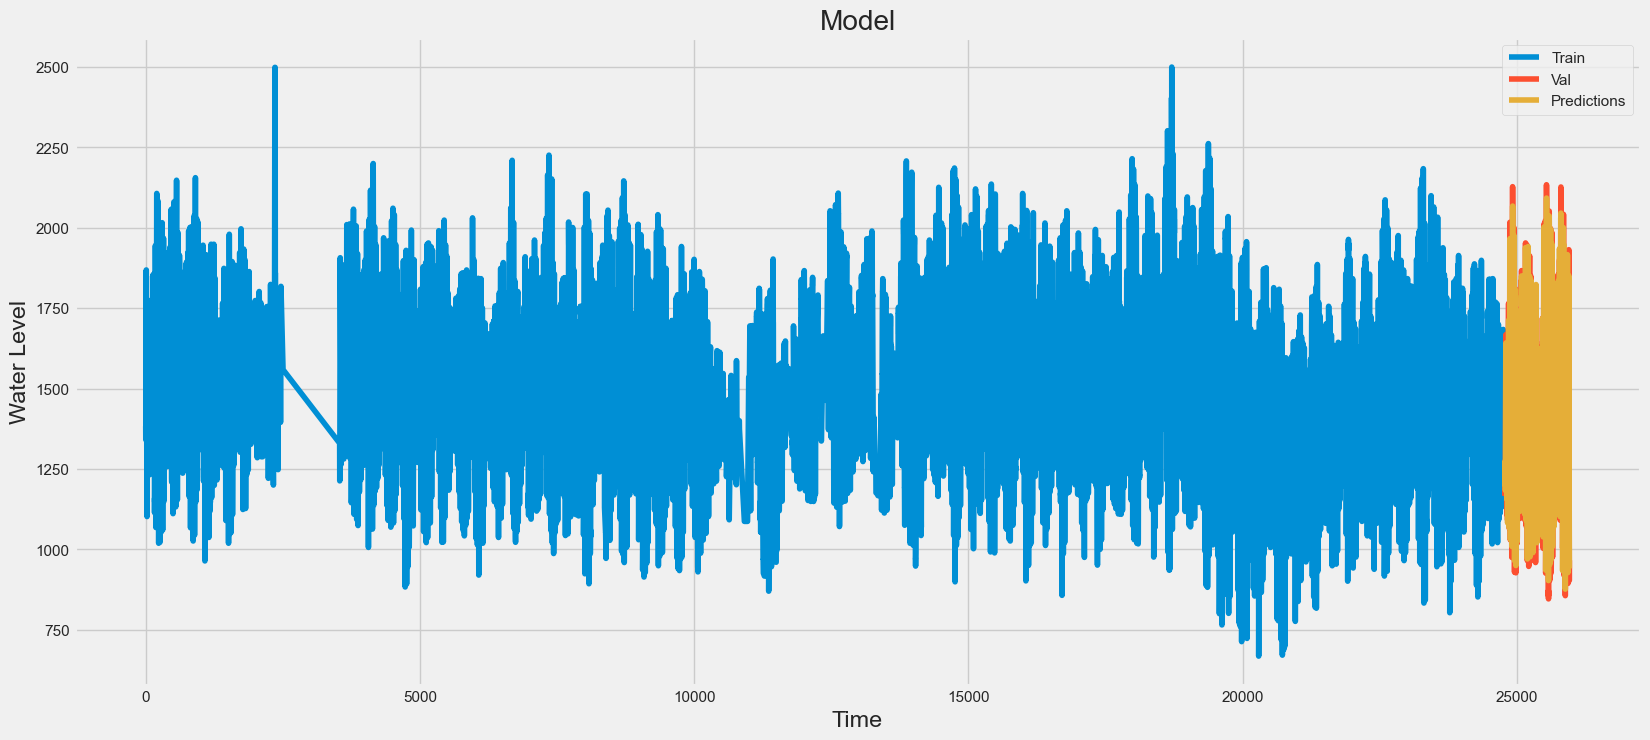

In [19]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(18,8))
plt.title('Model')
plt.xlabel('Time'), #fontsize=18)
plt.ylabel('Water Level'), #fontsize=18)
plt.plot(train['Water level'])
plt.plot(valid[['Water level', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.savefig('Model LSTM Water level.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Show the valid and predicted prices
valid

,Water level,Predictions
24785,1166.0,1225.492310
24786,1207.0,1200.682983
24787,1206.0,1224.522705
24788,1273.0,1227.303589
24789,1226.0,1274.580078
...,...,...
25955,1236.0,1232.517090
25956,1109.0,1152.587524
25957,957.0,1076.273193
25958,903.0,976.201477


In [27]:
import pickle

In [29]:
filename ='pasut_model.sav'
pickle.dump(model, open(filename,'wb'))

In [22]:
model.save("/content/drive/MyDrive/Dataset/Proyek Akhir/model.h5")